## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [3]:
# Load data:
df = pd.read_csv("data/house_prices.csv")

In [4]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [5]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

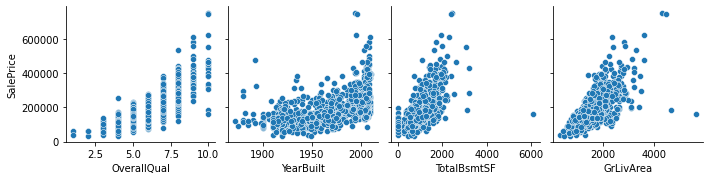

In [6]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [7]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] / 1e5 # Get the target values but in a smaller range.

In [8]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [9]:
# Normalize according to train set
X_mean = X_train.mean()
X_std = X_train.std()
y_mean = y_train.mean()
y_std = y_train.std()


def normalize(X, y, X_mean, y_mean, X_std, y_std):
    return (X - X_mean)/X_std, (y - y_mean)/y_std

# Only normalize the input, let's keep the y pre-normalized
X_train, _ = normalize(X_train, y_train, X_mean, y_mean, X_std, y_std)
X_val, _ = normalize(X_val, y_val, X_mean, y_mean, X_std, y_std)
X_test, _ = normalize(X_test, y_test, X_mean, y_mean, X_std, y_std)

train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float().view(-1, 1))
val_set = TensorDataset(torch.from_numpy(np.array(X_val)).float(), 
                          torch.from_numpy(np.array(y_val)).float().view(-1, 1))
test_set = TensorDataset(torch.from_numpy(np.array(X_test)).float(), 
                          torch.from_numpy(np.array(y_test)).float().view(-1, 1))

In [10]:
# Construct a model with one layer
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l1 = nn.Linear(4, 1)

    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [245]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [246]:
def train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, val_criterion=None, verbose=True):
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    if val_criterion is None:
        val_criterion = criterion
    best_val = torch.tensor(np.inf)
    losses = np.zeros((2, num_epochs))
    for epoch in range(num_epochs):
        model.train()
        epoch_average_loss = 0.0
        for (X, y) in (train_loader):
            batch_size = X.shape[0]

            y_pre = model(X)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        losses[0, epoch] = epoch_average_loss    
        losses[1, epoch] = validate(model, val_set, val_criterion)

        if verbose:
                print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss, losses[1][epoch]))

        if losses[1, epoch] < best_val:
            best_val = losses[1, epoch]
            torch.save(model.state_dict(), "best_model.pt")
            if verbose:
                print(f"New best val loss, model saved in best_model.pt file")

    return losses


def validate(model, dataset, criterion):
    model.eval()
    with torch.no_grad():
        X, y = dataset.tensors
        y_pre = model(X)
        error = criterion(y_pre, y).item()
    return error

In [247]:
losses = train(30, batch_size, criterion, optimizer, model, train_set, val_set)

Epoch [1/30], Train_loss: 1.1553, Val_loss: 0.2545
New best val loss, model saved in best_model.pt file
Epoch [2/30], Train_loss: 0.1752, Val_loss: 0.1614
New best val loss, model saved in best_model.pt file
Epoch [3/30], Train_loss: 0.1430, Val_loss: 0.1516
New best val loss, model saved in best_model.pt file
Epoch [4/30], Train_loss: 0.1397, Val_loss: 0.1518
Epoch [5/30], Train_loss: 0.1385, Val_loss: 0.1534
Epoch [6/30], Train_loss: 0.1400, Val_loss: 0.1546
Epoch [7/30], Train_loss: 0.1368, Val_loss: 0.1570
Epoch [8/30], Train_loss: 0.1384, Val_loss: 0.1536
Epoch [9/30], Train_loss: 0.1389, Val_loss: 0.1548
Epoch [10/30], Train_loss: 0.1377, Val_loss: 0.1537
Epoch [11/30], Train_loss: 0.1385, Val_loss: 0.1570
Epoch [12/30], Train_loss: 0.1392, Val_loss: 0.1545
Epoch [13/30], Train_loss: 0.1381, Val_loss: 0.1626
Epoch [14/30], Train_loss: 0.1393, Val_loss: 0.1598
Epoch [15/30], Train_loss: 0.1398, Val_loss: 0.1556
Epoch [16/30], Train_loss: 0.1389, Val_loss: 0.1546
Epoch [17/30], Tra

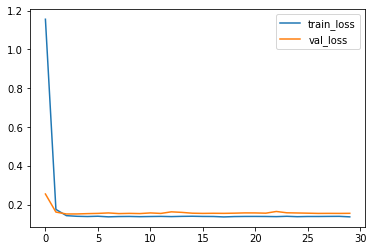

In [248]:
plt.plot(losses[0], label="train_loss")
plt.plot(losses[1], label="val_loss")
plt.legend()
plt.show()

In [249]:
print("Val loss min:", min(losses[1]))

Val loss min: 0.15158958733081818


In [250]:
# MAE in €

model.load_state_dict(torch.load("best_model.pt"))
val_criterion = nn.L1Loss()
validate(model, val_set, val_criterion) * 1e5

26547.26803302765

In [281]:
# Baseline: Predict the mean and check MAE in € (To be sure to beat this!)

MAE = np.mean(np.abs((np.array(y_train) - y_mean))) * 1e5
RMSE = np.sqrt(np.mean((np.array(y_train) - y_mean)**2)) * 1e5

print(f"MEAN PREDICTOR => MAE in €: {MAE}, MSE_loss: {RMSE}")

MEAN PREDICTOR => MAE in €: 58695.849436000004, MSE_loss: 80251.05955823636


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

In [34]:
# Construct a model with one layer
class Model(nn.Module):    
    def __init__(self, sizes=(4, 1), activation=nn.ReLU):
        super(Model, self).__init__()

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.net(inputs)

In [35]:
# First benchmark

# Use a little bit more epochs (20) and a bigger batch_size (see next part)
# This is done to stabilize training and do enough epochs to reach best results
# (extract best val_loss computed at each epoch)
# And average over 5 trials to reduce variability
N = 5
num_epochs = 20
batch_size = 20 # If too big 20 epochs won't be enough. If too small to much variability.
criterion = nn.MSELoss()

depths = [1, 2, 3]  # Number of hidden layers
widths = [5, 10, 20]  # Number of neurones in each layer
activations = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.ELU]

results = np.zeros((len(depths), len(widths), len(activations)))


for i, depth in enumerate(depths):
    for j, width in enumerate(widths):
        for k, activation in enumerate(activations):
            print(i, j, k)
            for _ in range(N):
                model = Model([4] + [width]*depth + [1], activation)
                optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
                val_losses = train(
                    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
                )[1]
                results[i, j, k] += min(val_losses)
results /= N

results_first_benchmark = results

0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3


In [36]:
argmin = results.argmin()
k = argmin % len(activations)
j = (argmin // len(activations)) % len(widths)
i = ((argmin // len(activations)) // len(widths)) % len(depths)

print(results[i, j, k], results.min())

print(f"Best: {activations[k].__name__} with {depths[i]} hidden layer(s) and {widths[j]} neurones each", )

0.11088736206293107 0.11088736206293107
Best: ReLU with 2 hidden layer(s) and 20 neurones each


In [37]:
# Results activation: ReLU is best in our case followed by ELU

results.argmin(axis=2), results[:, :, 0], results[:, :, 1], results[:, :, 2], results[:, :, 3]

(array([[2, 2, 2],
        [2, 2, 2],
        [2, 3, 2]]),
 array([[0.23454874, 0.22194117, 0.20573565],
        [0.56997067, 0.40902644, 0.31736296],
        [0.71383133, 0.71278083, 0.70601079]]),
 array([[0.20705038, 0.19917977, 0.18919415],
        [0.21280912, 0.20214032, 0.19607   ],
        [0.20241201, 0.19760462, 0.19041952]]),
 array([[0.12111018, 0.11710154, 0.11448616],
        [0.12109976, 0.11887593, 0.11088736],
        [0.12795684, 0.15247198, 0.11253865]]),
 array([[0.13107947, 0.12700377, 0.11617321],
        [0.13039473, 0.12617897, 0.12209786],
        [0.14885304, 0.1460831 , 0.12918819]]))

In [38]:
# Results width: ~ The more the best

results.argmin(axis=1), results[:, 0, :], results[:, 1, :], results[:, 2, :]

(array([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2]]),
 array([[0.23454874, 0.20705038, 0.12111018, 0.13107947],
        [0.56997067, 0.21280912, 0.12109976, 0.13039473],
        [0.71383133, 0.20241201, 0.12795684, 0.14885304]]),
 array([[0.22194117, 0.19917977, 0.11710154, 0.12700377],
        [0.40902644, 0.20214032, 0.11887593, 0.12617897],
        [0.71278083, 0.19760462, 0.15247198, 0.1460831 ]]),
 array([[0.20573565, 0.18919415, 0.11448616, 0.11617321],
        [0.31736296, 0.19607   , 0.11088736, 0.12209786],
        [0.70601079, 0.19041952, 0.11253865, 0.12918819]]))

In [39]:
# Results depths: Unclear

results.argmin(axis=0), results[0, :, :], results[1, :, :], results[2, :, :]

(array([[0, 2, 1, 1],
        [0, 2, 0, 1],
        [0, 0, 1, 0]]),
 array([[0.23454874, 0.20705038, 0.12111018, 0.13107947],
        [0.22194117, 0.19917977, 0.11710154, 0.12700377],
        [0.20573565, 0.18919415, 0.11448616, 0.11617321]]),
 array([[0.56997067, 0.21280912, 0.12109976, 0.13039473],
        [0.40902644, 0.20214032, 0.11887593, 0.12617897],
        [0.31736296, 0.19607   , 0.11088736, 0.12209786]]),
 array([[0.71383133, 0.20241201, 0.12795684, 0.14885304],
        [0.71278083, 0.19760462, 0.15247198, 0.1460831 ],
        [0.70601079, 0.19041952, 0.11253865, 0.12918819]]))

In [40]:
# Second benchmark check more neurones

N = 5
num_epochs = 20
batch_size = 20
criterion = nn.MSELoss()

depths = [1, 2, 3, 4]
widths = [20, 40, 80, 100]
activation = nn.ReLU

results = np.zeros((len(depths), len(widths)))

for i, depth in enumerate(depths):
    for j, width in enumerate(widths):
        print(i, j)
        for _ in range(N):
            model = Model([4] + [width]*depth + [1], activation)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
            val_losses = train(
                num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
            )[1]
            results[i, j] += min(val_losses)
results /= N

results_second_benchmark = results

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


In [41]:
argmin = results.argmin()
j = argmin % len(widths)
i = (argmin // len(widths)) % len(depths)

print(results[i, j], results.min())

print(f"Best: {depths[i]} hidden layer(s) and {widths[j]} neurones each", )

0.1016223207116127 0.1016223207116127
Best: 1 hidden layer(s) and 100 neurones each


In [43]:
# Results width: Seems that we can put even more neurones

results.argmin(axis=1), results[:, 0], results[:, 1], results[:, 2], results[:, 3]

(array([3, 3, 3, 2]),
 array([0.11118646, 0.11219586, 0.11293987, 0.11367263]),
 array([0.11341623, 0.11197382, 0.10848131, 0.11150655]),
 array([0.10888995, 0.10377565, 0.10538298, 0.10550597]),
 array([0.10162232, 0.1020957 , 0.10508302, 0.10679738]))

In [44]:
# Results depth: Still unclear

results.argmin(axis=0), results[0, :], results[1, :], results[2, :], results[3,:]

(array([0, 2, 1, 0]),
 array([0.11118646, 0.11341623, 0.10888995, 0.10162232]),
 array([0.11219586, 0.11197382, 0.10377565, 0.1020957 ]),
 array([0.11293987, 0.10848131, 0.10538298, 0.10508302]),
 array([0.11367263, 0.11150655, 0.10550597, 0.10679738]))

In [226]:
# Best we got:

num_epochs = 20
batch_size = 20
criterion = nn.MSELoss()

model = Model((4, 100, 1), nn.ReLU)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
val_losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=True,
)

model.load_state_dict(torch.load("best_model.pt"))
val_criterion = nn.L1Loss()
validate(model, val_set, val_criterion) * 1e5

Epoch [1/20], Train_loss: 0.4441, Val_loss: 0.2233
New best val loss, model saved in best_model.pt file
Epoch [2/20], Train_loss: 0.1638, Val_loss: 0.1408
New best val loss, model saved in best_model.pt file
Epoch [3/20], Train_loss: 0.1527, Val_loss: 0.1302
New best val loss, model saved in best_model.pt file
Epoch [4/20], Train_loss: 0.1437, Val_loss: 0.1247
New best val loss, model saved in best_model.pt file
Epoch [5/20], Train_loss: 0.1329, Val_loss: 0.1228
New best val loss, model saved in best_model.pt file
Epoch [6/20], Train_loss: 0.1323, Val_loss: 0.1185
New best val loss, model saved in best_model.pt file
Epoch [7/20], Train_loss: 0.1220, Val_loss: 0.1489
Epoch [8/20], Train_loss: 0.1238, Val_loss: 0.1153
New best val loss, model saved in best_model.pt file
Epoch [9/20], Train_loss: 0.1221, Val_loss: 0.1148
New best val loss, model saved in best_model.pt file
Epoch [10/20], Train_loss: 0.1188, Val_loss: 0.1150
Epoch [11/20], Train_loss: 0.1202, Val_loss: 0.1090
New best val 

22284.092009067535

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [46]:
# Impact of epochs and batch_size for a given model

sizes = (4, 20, 20, 1)
activation = nn.ReLU

num_epochs = 100  # Check the val loss at each epochs
batch_sizes = [10, 64, 128, 256]

criterion = nn.MSELoss()

N = 5

val_losses = np.zeros((len(batch_sizes), num_epochs, N))

for k, batch_size in enumerate(batch_sizes):
    print(k)
    for n in range(N):
        model = Model(sizes, activation)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        val_losses[k, :, n] = train(
            num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
        )[1]
val_losses_batch_size = val_losses

0
1
2
3


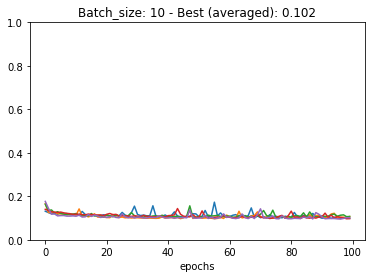

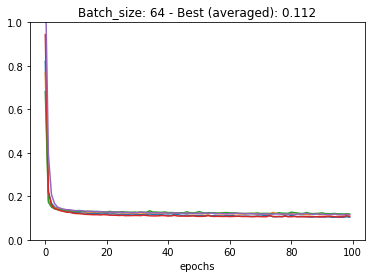

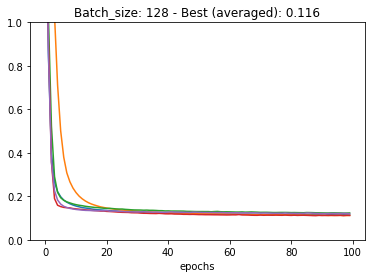

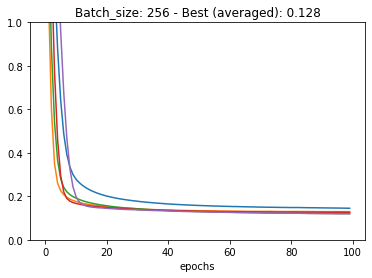

In [47]:
for k, batch_size in enumerate(batch_sizes):
    best = val_losses[k].mean(axis=1).min()
    plt.title(f"Batch_size: {batch_size} - Best (averaged): {best:.3f}")
    plt.ylim(0, 1)
    plt.plot(val_losses[k, :])
    plt.xlabel("epochs")
    plt.show()

In [ ]:
# Results batch_size: Small -> Faster convergence (as more step by epochs) but noisier
# Big -> stable but slower.
# Best averaged reached for batch of 10.

In [ ]:
# Results epochs: Improves results, we don't observe overfitting.

In [252]:
# Try to find overfitting:

sizes = (4, 100, 100, 100, 100, 100, 1)
activation = nn.ReLU

num_epochs = 1000  # Check the val loss at each epochs
batch_size = 64 # Small enough to learn quick, but as only one run try to be stable too.

criterion = nn.MSELoss()

model = Model(sizes, activation)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=True,
)

Epoch [1/1000], Train_loss: 2.9152, Val_loss: 1.7831
New best val loss, model saved in best_model.pt file
Epoch [2/1000], Train_loss: 1.2314, Val_loss: 0.7189
New best val loss, model saved in best_model.pt file
Epoch [3/1000], Train_loss: 0.4800, Val_loss: 0.3643
New best val loss, model saved in best_model.pt file
Epoch [4/1000], Train_loss: 0.2742, Val_loss: 0.2525
New best val loss, model saved in best_model.pt file
Epoch [5/1000], Train_loss: 0.1996, Val_loss: 0.1901
New best val loss, model saved in best_model.pt file
Epoch [6/1000], Train_loss: 0.1632, Val_loss: 0.1584
New best val loss, model saved in best_model.pt file
Epoch [7/1000], Train_loss: 0.1467, Val_loss: 0.1440
New best val loss, model saved in best_model.pt file
Epoch [8/1000], Train_loss: 0.1410, Val_loss: 0.1375
New best val loss, model saved in best_model.pt file
Epoch [9/1000], Train_loss: 0.1387, Val_loss: 0.1340
New best val loss, model saved in best_model.pt file
Epoch [10/1000], Train_loss: 0.1362, Val_loss:

Epoch [111/1000], Train_loss: 0.0992, Val_loss: 0.0993
New best val loss, model saved in best_model.pt file
Epoch [112/1000], Train_loss: 0.1016, Val_loss: 0.1007
Epoch [113/1000], Train_loss: 0.1009, Val_loss: 0.0986
New best val loss, model saved in best_model.pt file
Epoch [114/1000], Train_loss: 0.1019, Val_loss: 0.0983
New best val loss, model saved in best_model.pt file
Epoch [115/1000], Train_loss: 0.1004, Val_loss: 0.0980
New best val loss, model saved in best_model.pt file
Epoch [116/1000], Train_loss: 0.1004, Val_loss: 0.1012
Epoch [117/1000], Train_loss: 0.1015, Val_loss: 0.1011
Epoch [118/1000], Train_loss: 0.0990, Val_loss: 0.0992
Epoch [119/1000], Train_loss: 0.1003, Val_loss: 0.0995
Epoch [120/1000], Train_loss: 0.1014, Val_loss: 0.0988
Epoch [121/1000], Train_loss: 0.0990, Val_loss: 0.1107
Epoch [122/1000], Train_loss: 0.1009, Val_loss: 0.1044
Epoch [123/1000], Train_loss: 0.1024, Val_loss: 0.0999
Epoch [124/1000], Train_loss: 0.1008, Val_loss: 0.1190
Epoch [125/1000], 

Epoch [254/1000], Train_loss: 0.0927, Val_loss: 0.0967
Epoch [255/1000], Train_loss: 0.0919, Val_loss: 0.0950
Epoch [256/1000], Train_loss: 0.0908, Val_loss: 0.0977
Epoch [257/1000], Train_loss: 0.0927, Val_loss: 0.0961
Epoch [258/1000], Train_loss: 0.0916, Val_loss: 0.0970
Epoch [259/1000], Train_loss: 0.0927, Val_loss: 0.0984
Epoch [260/1000], Train_loss: 0.0904, Val_loss: 0.0966
Epoch [261/1000], Train_loss: 0.0920, Val_loss: 0.0976
Epoch [262/1000], Train_loss: 0.0935, Val_loss: 0.1012
Epoch [263/1000], Train_loss: 0.0917, Val_loss: 0.0954
Epoch [264/1000], Train_loss: 0.0915, Val_loss: 0.0963
Epoch [265/1000], Train_loss: 0.0923, Val_loss: 0.0959
Epoch [266/1000], Train_loss: 0.0905, Val_loss: 0.1026
Epoch [267/1000], Train_loss: 0.0934, Val_loss: 0.0983
Epoch [268/1000], Train_loss: 0.0917, Val_loss: 0.0953
Epoch [269/1000], Train_loss: 0.0915, Val_loss: 0.0954
Epoch [270/1000], Train_loss: 0.0906, Val_loss: 0.0969
Epoch [271/1000], Train_loss: 0.0923, Val_loss: 0.0966
Epoch [272

Epoch [408/1000], Train_loss: 0.0850, Val_loss: 0.0970
Epoch [409/1000], Train_loss: 0.0845, Val_loss: 0.1037
Epoch [410/1000], Train_loss: 0.0871, Val_loss: 0.0964
Epoch [411/1000], Train_loss: 0.0852, Val_loss: 0.0972
Epoch [412/1000], Train_loss: 0.0853, Val_loss: 0.1020
Epoch [413/1000], Train_loss: 0.0873, Val_loss: 0.0940
Epoch [414/1000], Train_loss: 0.0869, Val_loss: 0.0951
Epoch [415/1000], Train_loss: 0.0851, Val_loss: 0.0939
Epoch [416/1000], Train_loss: 0.0856, Val_loss: 0.0953
Epoch [417/1000], Train_loss: 0.0845, Val_loss: 0.0957
Epoch [418/1000], Train_loss: 0.0870, Val_loss: 0.0935
Epoch [419/1000], Train_loss: 0.0841, Val_loss: 0.0969
Epoch [420/1000], Train_loss: 0.0842, Val_loss: 0.0926
New best val loss, model saved in best_model.pt file
Epoch [421/1000], Train_loss: 0.0860, Val_loss: 0.0940
Epoch [422/1000], Train_loss: 0.0845, Val_loss: 0.0931
Epoch [423/1000], Train_loss: 0.0861, Val_loss: 0.0940
Epoch [424/1000], Train_loss: 0.0843, Val_loss: 0.1041
Epoch [425/1

Epoch [548/1000], Train_loss: 0.0812, Val_loss: 0.0911
Epoch [549/1000], Train_loss: 0.0813, Val_loss: 0.0918
Epoch [550/1000], Train_loss: 0.0795, Val_loss: 0.0930
Epoch [551/1000], Train_loss: 0.0795, Val_loss: 0.0886
New best val loss, model saved in best_model.pt file
Epoch [552/1000], Train_loss: 0.0801, Val_loss: 0.0948
Epoch [553/1000], Train_loss: 0.0784, Val_loss: 0.0920
Epoch [554/1000], Train_loss: 0.0792, Val_loss: 0.0928
Epoch [555/1000], Train_loss: 0.0783, Val_loss: 0.0895
Epoch [556/1000], Train_loss: 0.0804, Val_loss: 0.0981
Epoch [557/1000], Train_loss: 0.0809, Val_loss: 0.0921
Epoch [558/1000], Train_loss: 0.0793, Val_loss: 0.0905
Epoch [559/1000], Train_loss: 0.0805, Val_loss: 0.0934
Epoch [560/1000], Train_loss: 0.0767, Val_loss: 0.1124
Epoch [561/1000], Train_loss: 0.0821, Val_loss: 0.0905
Epoch [562/1000], Train_loss: 0.0771, Val_loss: 0.0945
Epoch [563/1000], Train_loss: 0.0810, Val_loss: 0.0890
Epoch [564/1000], Train_loss: 0.0770, Val_loss: 0.0889
Epoch [565/1

Epoch [688/1000], Train_loss: 0.0721, Val_loss: 0.0886
Epoch [689/1000], Train_loss: 0.0721, Val_loss: 0.0851
New best val loss, model saved in best_model.pt file
Epoch [690/1000], Train_loss: 0.0721, Val_loss: 0.0859
Epoch [691/1000], Train_loss: 0.0700, Val_loss: 0.0870
Epoch [692/1000], Train_loss: 0.0749, Val_loss: 0.0890
Epoch [693/1000], Train_loss: 0.0728, Val_loss: 0.0867
Epoch [694/1000], Train_loss: 0.0693, Val_loss: 0.0891
Epoch [695/1000], Train_loss: 0.0704, Val_loss: 0.0886
Epoch [696/1000], Train_loss: 0.0691, Val_loss: 0.1049
Epoch [697/1000], Train_loss: 0.0690, Val_loss: 0.0860
Epoch [698/1000], Train_loss: 0.0711, Val_loss: 0.0876
Epoch [699/1000], Train_loss: 0.0718, Val_loss: 0.0886
Epoch [700/1000], Train_loss: 0.0691, Val_loss: 0.0871
Epoch [701/1000], Train_loss: 0.0704, Val_loss: 0.0898
Epoch [702/1000], Train_loss: 0.0682, Val_loss: 0.0884
Epoch [703/1000], Train_loss: 0.0714, Val_loss: 0.0894
Epoch [704/1000], Train_loss: 0.0705, Val_loss: 0.0848
New best val

Epoch [830/1000], Train_loss: 0.0640, Val_loss: 0.0936
Epoch [831/1000], Train_loss: 0.0632, Val_loss: 0.0836
Epoch [832/1000], Train_loss: 0.0638, Val_loss: 0.0832
Epoch [833/1000], Train_loss: 0.0621, Val_loss: 0.0861
Epoch [834/1000], Train_loss: 0.0699, Val_loss: 0.0839
Epoch [835/1000], Train_loss: 0.0635, Val_loss: 0.0831
Epoch [836/1000], Train_loss: 0.0624, Val_loss: 0.1132
Epoch [837/1000], Train_loss: 0.0637, Val_loss: 0.0952
Epoch [838/1000], Train_loss: 0.0631, Val_loss: 0.0837
Epoch [839/1000], Train_loss: 0.0628, Val_loss: 0.0830
New best val loss, model saved in best_model.pt file
Epoch [840/1000], Train_loss: 0.0615, Val_loss: 0.0839
Epoch [841/1000], Train_loss: 0.0616, Val_loss: 0.0836
Epoch [842/1000], Train_loss: 0.0613, Val_loss: 0.0877
Epoch [843/1000], Train_loss: 0.0610, Val_loss: 0.0886
Epoch [844/1000], Train_loss: 0.0620, Val_loss: 0.0850
Epoch [845/1000], Train_loss: 0.0626, Val_loss: 0.0849
Epoch [846/1000], Train_loss: 0.0630, Val_loss: 0.0830
Epoch [847/1

Epoch [978/1000], Train_loss: 0.0577, Val_loss: 0.0933
Epoch [979/1000], Train_loss: 0.0570, Val_loss: 0.0873
Epoch [980/1000], Train_loss: 0.0573, Val_loss: 0.0836
Epoch [981/1000], Train_loss: 0.0578, Val_loss: 0.0886
Epoch [982/1000], Train_loss: 0.0546, Val_loss: 0.0825
Epoch [983/1000], Train_loss: 0.0589, Val_loss: 0.0826
Epoch [984/1000], Train_loss: 0.0576, Val_loss: 0.0829
Epoch [985/1000], Train_loss: 0.0578, Val_loss: 0.0862
Epoch [986/1000], Train_loss: 0.0582, Val_loss: 0.0820
New best val loss, model saved in best_model.pt file
Epoch [987/1000], Train_loss: 0.0548, Val_loss: 0.0922
Epoch [988/1000], Train_loss: 0.0591, Val_loss: 0.1410
Epoch [989/1000], Train_loss: 0.0656, Val_loss: 0.0849
Epoch [990/1000], Train_loss: 0.0559, Val_loss: 0.0951
Epoch [991/1000], Train_loss: 0.0554, Val_loss: 0.0839
Epoch [992/1000], Train_loss: 0.0555, Val_loss: 0.0828
Epoch [993/1000], Train_loss: 0.0608, Val_loss: 0.0832
Epoch [994/1000], Train_loss: 0.0553, Val_loss: 0.0887
Epoch [995/1

19500.166177749634


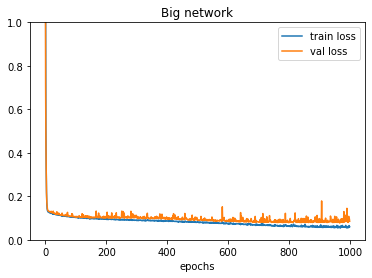

In [51]:
model.load_state_dict(torch.load("best_model.pt"))
val_criterion = nn.L1Loss()
best_score = validate(model, val_set, val_criterion) * 1e5

print(best_score)  # no real overfitting... Best reached at epochs > 900

plt.title(f"Big network")
plt.ylim(0, 1)
plt.plot(losses[0], label="train loss")
plt.plot(losses[1], label="val loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [52]:
# Adam

sizes = (4, 20, 20, 1)
activation = nn.ReLU

N = 5
num_epochs = 100
batch_sizes = [10, 64, 128, 256]

criterion = nn.MSELoss()

val_losses = np.zeros((len(batch_sizes), num_epochs, N))

for k, batch_size in enumerate(batch_sizes):
    print(k)
    for n in range(N):
        model = Model(sizes, activation)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        val_losses[k, :, n] = train(
            num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
        )[1]
val_losses_adam = val_losses

0
1
2
3


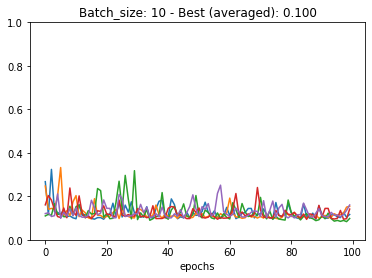

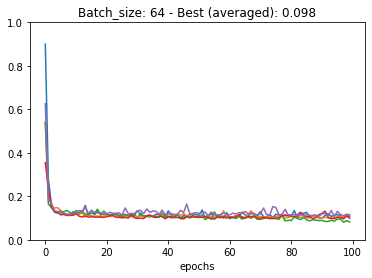

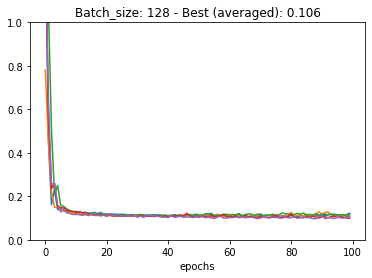

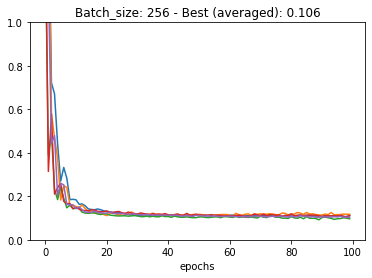

In [53]:
for k, batch_size in enumerate(batch_sizes):
    best = val_losses[k].mean(axis=1).min()
    plt.title(f"Batch_size: {batch_size} - Best (averaged): {best:.3f}")
    plt.ylim(0, 1)
    plt.plot(val_losses[k, :])
    plt.xlabel("epochs")
    plt.show()

In [54]:
# RMSProp

sizes = (4, 20, 20, 1)
activation = nn.ReLU

N = 5
num_epochs = 100
batch_sizes = [10, 64, 128, 256]

criterion = nn.MSELoss()

val_losses = np.zeros((len(batch_sizes), num_epochs, N))

for k, batch_size in enumerate(batch_sizes):
    print(k)
    for n in range(N):
        model = Model(sizes, activation)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
        val_losses[k, :, n] = train(
            num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
        )[1]
val_losses_rms = val_losses

0
1
2
3


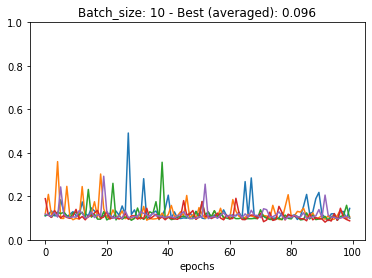

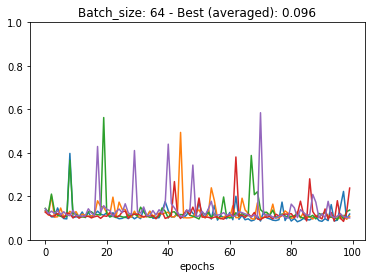

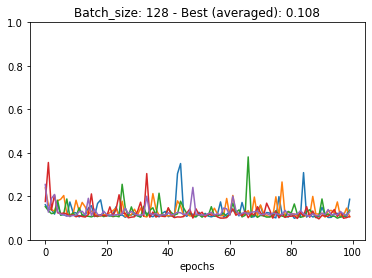

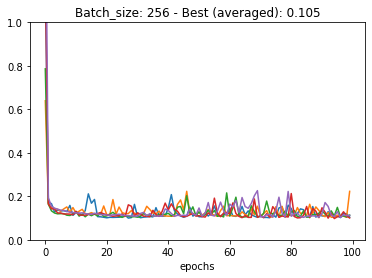

In [56]:
for k, batch_size in enumerate(batch_sizes):
    best = val_losses[k].mean(axis=1).min()
    plt.title(f"Batch_size: {batch_size} - Best (averaged): {best:.3f}")
    plt.ylim(0, 1)
    plt.plot(val_losses[k, :])
    plt.xlabel("epochs")
    plt.show()

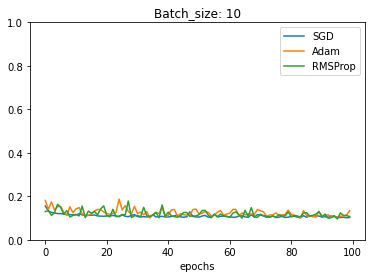

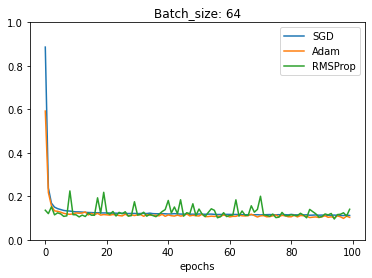

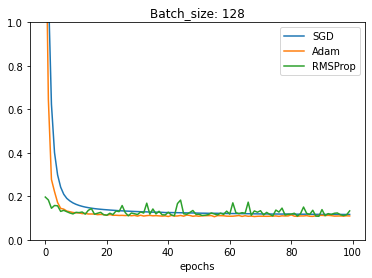

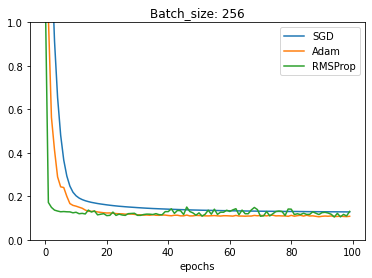

In [57]:
for k, batch_size in enumerate(batch_sizes):
    sgd_loss = val_losses_batch_size[k].mean(axis=1)
    adam_loss = val_losses_adam[k].mean(axis=1)
    rms_loss = val_losses_rms[k].mean(axis=1)
    plt.title(f"Batch_size: {batch_size}")
    plt.ylim(0, 1)
    plt.plot(sgd_loss, label="SGD")
    plt.plot(adam_loss, label="Adam")
    plt.plot(rms_loss, label="RMSProp")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [ ]:
# Results optimizer: Adam outperforms SGD.
# RMSProp even faster but much more noisy. Adam seems better (stable and almost as fast)

In [58]:
# Check learning rates

# Use Adam so that 40 epochs is enough with 0.01 and stable with batch_size of 64
num_epochs = 40  
batch_size = 64

learning_rates = [1e-3, 1e-2, 1e-1, 1]
sizes = [(4, 6, 1), (4, 10, 10, 1), (4, 20, 100, 20, 1)]
activation = nn.ReLU

criterion = nn.MSELoss()

val_losses = np.zeros((len(sizes), len(learning_rates), num_epochs))


for i, size in enumerate(sizes):
    for k, lr in enumerate(learning_rates):
        print(i, k)
        model = Model(size, activation)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        val_losses[i, k, :] = train(
            num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
        )[1]
val_losses_lr = val_losses

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3


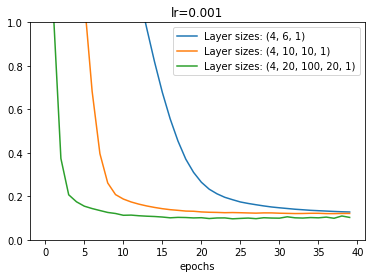

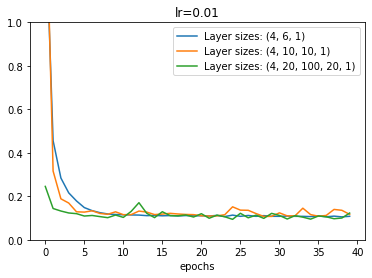

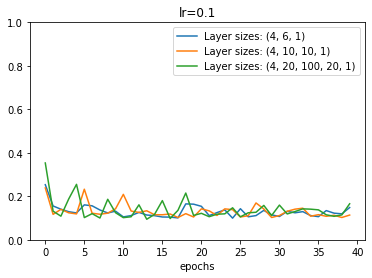

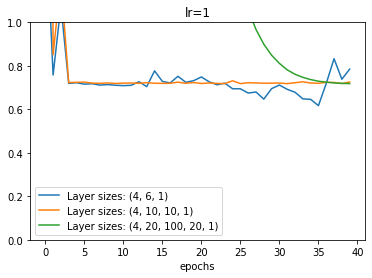

In [59]:
for k, lr in enumerate(learning_rates):
    plt.title(f"lr={lr}")
    for i, size in enumerate(sizes):
        plt.plot(val_losses[i, k], label=f"Layer sizes: {size}")
    plt.ylim(0, 1)
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [ ]:
# Results LR: Depends on the size of the network. Small LR for bigger network otherwise much variability

# Good lr <= 0.1

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


In [110]:
# New model: It's basically two separate models train together: One to compute mu, the other for sigma.
# It works but no real use
class ModelBis(nn.Module):    
    def __init__(self, sizes=(4, 1), activation=nn.ReLU):
        super().__init__()

        layers_mu = []
        layers_sigma = []
        for i in range(len(sizes) - 2):
            layers_mu.append(nn.Linear(sizes[i], sizes[i+1]))
            layers_mu.append(activation())
            layers_sigma.append(nn.Linear(sizes[i], sizes[i+1]))
            layers_sigma.append(activation())
        layers_mu.append(nn.Linear(sizes[-2], sizes[-1]))
        layers_sigma.append(nn.Linear(sizes[-2], sizes[-1]))

        self.mu_net = nn.Sequential(*layers_mu)
        self.sigma_net = nn.Sequential(*layers_sigma)

    def forward(self, inputs):
        mu = self.mu_net(inputs)
        sigma = self.sigma_net(inputs)
        return torch.cat((mu, sigma), dim=1)

In [181]:
def normal_loss(prediction, target):
    """Loss describe above

    Args:
        prediction: Shape: (None, 2) -> mu_i, log(sigma_i^2)
        target: Shape: (None, 1) or (None,) -> y_i
    """
    mu, log_sigma_2 = prediction[..., 0], prediction[..., 1]  # Shape (None,)
    MSE = (target.view(-1) - mu)**2  # Shape: (None,)
    # Don't keep constant term nor 1/2 multiplier => Fit the MSELoss when sigma = 1
    unreduced = log_sigma_2 + MSE/torch.exp(log_sigma_2) # Shape (None,)
    return unreduced.mean()

In [142]:
# Criterion over mu only
class MuCriterion:
    def __init__(self, criterion=nn.L1Loss()):
        self.criterion = criterion

    def __call__(self, prediction, target):
        return self.criterion(prediction[..., 0:1], target)

In [275]:
hidden_sizes = [100, 100, 100, 100, 100, 100, 100]

model = Model([4] + hidden_sizes + [2], nn.ReLU)
# model = ModelBis([4] + hidden_sizes + [2], nn.ReLU)
print(model)

num_epochs = 300
batch_size = 64
lr = 0.005

criterion = normal_loss
# val_criterion = MuCriterion(nn.L1Loss())
val_criterion = None
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, val_criterion, verbose=True,
)

Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=2, bias=True)
  )
)
Epoch [1/300], Train_loss: 1.3902, Val_loss: 0.3723
New best val loss, model saved in best_model.pt file
Epoch [2/300], Train_loss: -0.0698, Val_loss: -0.0781
New best val loss, model saved in best_model.pt file
Epoch [3/300], Train_loss: 0.5528, Val_loss: 1.7346
Epoch [4/300], Train_loss: 1.2611, Val_loss: 0.8475
Epoch [5/300], Train_loss: 0.4474, Val_lo

Epoch [131/300], Train_loss: -2.4775, Val_loss: -0.1333
Epoch [132/300], Train_loss: -2.5603, Val_loss: -0.2913
Epoch [133/300], Train_loss: -2.5781, Val_loss: -0.2355
Epoch [134/300], Train_loss: -2.5327, Val_loss: -0.8599
Epoch [135/300], Train_loss: -2.1678, Val_loss: -0.3310
Epoch [136/300], Train_loss: -2.4796, Val_loss: -0.7254
Epoch [137/300], Train_loss: -2.4362, Val_loss: -0.8362
Epoch [138/300], Train_loss: -2.3700, Val_loss: -0.2897
Epoch [139/300], Train_loss: -2.2947, Val_loss: 0.2656
Epoch [140/300], Train_loss: -2.4100, Val_loss: -1.0013
Epoch [141/300], Train_loss: -2.5787, Val_loss: -0.6199
Epoch [142/300], Train_loss: -2.5122, Val_loss: -0.5402
Epoch [143/300], Train_loss: -2.4180, Val_loss: -0.1380
Epoch [144/300], Train_loss: -2.5672, Val_loss: -0.9574
Epoch [145/300], Train_loss: -2.5489, Val_loss: -0.8056
Epoch [146/300], Train_loss: -2.5496, Val_loss: 0.8227
Epoch [147/300], Train_loss: -2.5992, Val_loss: 1.4760
Epoch [148/300], Train_loss: -2.6114, Val_loss: 0.5

Epoch [281/300], Train_loss: -2.9141, Val_loss: 1.5325
Epoch [282/300], Train_loss: -2.9493, Val_loss: 2.3730
Epoch [283/300], Train_loss: -2.8574, Val_loss: 4.7835
Epoch [284/300], Train_loss: -2.8158, Val_loss: 1.8200
Epoch [285/300], Train_loss: -2.7792, Val_loss: 4.0948
Epoch [286/300], Train_loss: -2.6024, Val_loss: 1.4488
Epoch [287/300], Train_loss: -2.7467, Val_loss: 2.0509
Epoch [288/300], Train_loss: -2.6961, Val_loss: 4.6041
Epoch [289/300], Train_loss: -2.8448, Val_loss: 1.4184
Epoch [290/300], Train_loss: -2.8497, Val_loss: 2.7197
Epoch [291/300], Train_loss: -2.9282, Val_loss: 4.2243
Epoch [292/300], Train_loss: -3.0124, Val_loss: 5.0647
Epoch [293/300], Train_loss: -2.9763, Val_loss: 1.5998
Epoch [294/300], Train_loss: -2.9035, Val_loss: 2.8332
Epoch [295/300], Train_loss: -2.8520, Val_loss: 3.7874
Epoch [296/300], Train_loss: -3.0221, Val_loss: 1.4903
Epoch [297/300], Train_loss: -2.8670, Val_loss: 2.6811
Epoch [298/300], Train_loss: -3.0487, Val_loss: 6.6417
Epoch [299

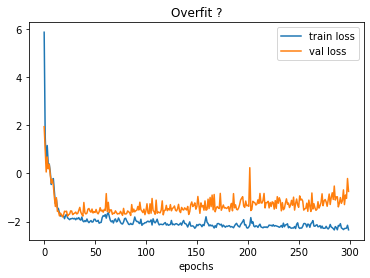

In [271]:
# Seems to overfit!

plt.title(f"Overfit ?")
plt.plot(losses[0], label="train loss")
plt.plot(losses[1], label="val loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [272]:
# But:
hidden_sizes = [100, 100, 100, 100, 100, 100, 100]

model = Model([4] + hidden_sizes + [2], nn.ReLU)
# model = ModelBis([4] + hidden_sizes + [2], nn.ReLU)
print(model)

num_epochs = 300
batch_size = 64
lr = 0.005

criterion = normal_loss
val_criterion = MuCriterion(nn.L1Loss())
# val_criterion = None
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, val_criterion, verbose=True,
)

# model.load_state_dict(torch.load("best_model.pt"))

Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=2, bias=True)
  )
)
Epoch [1/300], Train_loss: 1.5865, Val_loss: 0.5629
New best val loss, model saved in best_model.pt file
Epoch [2/300], Train_loss: 0.2983, Val_loss: 0.3238
New best val loss, model saved in best_model.pt file
Epoch [3/300], Train_loss: -0.0586, Val_loss: 0.3038
New best val loss, model saved in best_model.pt file
Epoch [4/300], Train_loss: 0.0638, Val_lo

Epoch [125/300], Train_loss: -2.4853, Val_loss: 0.2072
Epoch [126/300], Train_loss: -2.3705, Val_loss: 0.1979
Epoch [127/300], Train_loss: -2.4060, Val_loss: 0.2266
Epoch [128/300], Train_loss: -2.4230, Val_loss: 0.1967
Epoch [129/300], Train_loss: -2.5784, Val_loss: 0.1956
Epoch [130/300], Train_loss: -2.5488, Val_loss: 0.1935
Epoch [131/300], Train_loss: -2.5181, Val_loss: 0.1985
Epoch [132/300], Train_loss: -2.3383, Val_loss: 0.1967
Epoch [133/300], Train_loss: -2.2763, Val_loss: 0.2097
Epoch [134/300], Train_loss: -2.1896, Val_loss: 0.2127
Epoch [135/300], Train_loss: -2.3555, Val_loss: 0.2149
Epoch [136/300], Train_loss: -2.3002, Val_loss: 0.2121
Epoch [137/300], Train_loss: -2.4534, Val_loss: 0.1988
Epoch [138/300], Train_loss: -2.5271, Val_loss: 0.2047
Epoch [139/300], Train_loss: -2.4745, Val_loss: 0.1980
Epoch [140/300], Train_loss: -2.5573, Val_loss: 0.2007
Epoch [141/300], Train_loss: -2.6193, Val_loss: 0.1985
Epoch [142/300], Train_loss: -2.6369, Val_loss: 0.1979
Epoch [143

Epoch [276/300], Train_loss: -2.9693, Val_loss: 0.2139
Epoch [277/300], Train_loss: -2.7236, Val_loss: 0.2061
Epoch [278/300], Train_loss: -2.9580, Val_loss: 0.2061
Epoch [279/300], Train_loss: -3.0651, Val_loss: 0.2049
Epoch [280/300], Train_loss: -3.0479, Val_loss: 0.2138
Epoch [281/300], Train_loss: -2.9835, Val_loss: 0.2119
Epoch [282/300], Train_loss: -2.8978, Val_loss: 0.2176
Epoch [283/300], Train_loss: -3.0236, Val_loss: 0.2009
Epoch [284/300], Train_loss: -3.0058, Val_loss: 0.2214
Epoch [285/300], Train_loss: -3.1016, Val_loss: 0.2147
Epoch [286/300], Train_loss: -2.9284, Val_loss: 0.2169
Epoch [287/300], Train_loss: -2.9594, Val_loss: 0.2011
Epoch [288/300], Train_loss: -3.0489, Val_loss: 0.2153
Epoch [289/300], Train_loss: -2.8986, Val_loss: 0.2168
Epoch [290/300], Train_loss: -2.7216, Val_loss: 0.1990
Epoch [291/300], Train_loss: -2.8480, Val_loss: 0.2037
Epoch [292/300], Train_loss: -3.0084, Val_loss: 0.2074
Epoch [293/300], Train_loss: -2.9773, Val_loss: 0.2304
Epoch [294

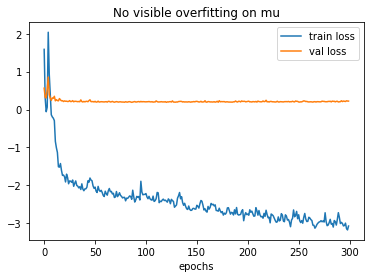

In [273]:
# Not visible on mu ! We probably overfit sigma !

plt.title(f"No visible overfitting on mu")
plt.plot(losses[0], label="train loss")
plt.plot(losses[1], label="val loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [274]:
val_criterion = MuCriterion()
validate(model, val_set, val_criterion) * 1e5

22132.63362646103

In [190]:
y_pre = model(val_set.tensors[0])

In [192]:
mu = y_pre[:, 0]
sigma = torch.sqrt(torch.exp(y_pre[:, 1]))

In [193]:
error = torch.abs(mu - val_set.tensors[1].squeeze())

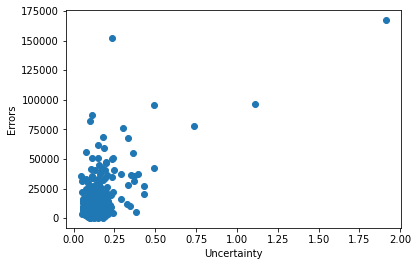

In [195]:
plt.xlabel("Uncertainty")
plt.ylabel("Errors")
plt.scatter(sigma.detach().numpy(), error.detach().numpy() * 1e5)
plt.show()

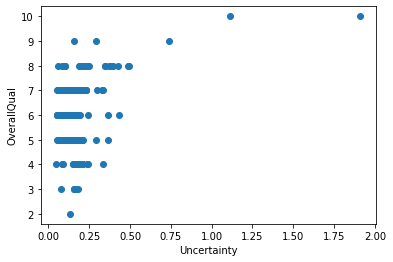

In [215]:
col = "OverallQual"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma.detach().numpy(), X_val[col] * X_std[col] + X_mean[col])
plt.show()

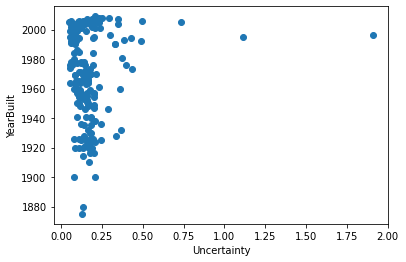

In [216]:
col = "YearBuilt"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma.detach().numpy(), X_val[col] * X_std[col] + X_mean[col])
plt.show()

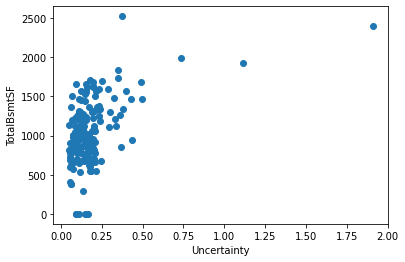

In [218]:
col = "TotalBsmtSF"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma.detach().numpy(), X_val[col] * X_std[col] + X_mean[col])
plt.show()

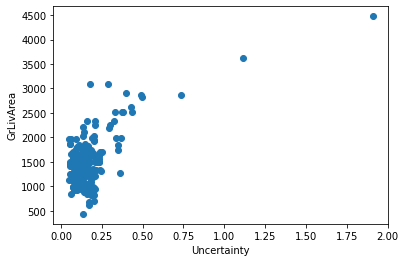

In [219]:
col = "GrLivArea"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma.detach().numpy(), X_val[col] * X_std[col] + X_mean[col])
plt.show()

### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

In [255]:
# Model:
sizes = [100, 100, 100, 100, 100]
activation = nn.ReLU

# First Loss
# Long train as it does not really overfit.
num_epochs = 1500
batch_size = 64

criterion = nn.MSELoss()

model = Model([4] + sizes + [1], activation)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
)

model.load_state_dict(torch.load("best_model.pt"))
val_criterion = nn.L1Loss()
print("MAE on test set:", validate(model, test_set, val_criterion) * 1e5)

MAE on test set: 21316.935122013092


In [261]:
# Second loss
model = Model([4] + sizes + [2], nn.ReLU)

num_epochs = 200
batch_size = 64
lr = 0.001

criterion = normal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(
    num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, verbose=False,
)

model.load_state_dict(torch.load("best_model.pt"))
val_criterion = MuCriterion()
print("MAE on test set:", validate(model, test_set, val_criterion) * 1e5)

MAE on test set: 22439.49919939041


In [262]:
y_pred = model(test_set.tensors[0])
sigma = torch.sqrt(torch.exp(y_pred[:, 1])).detach().cpu().numpy()

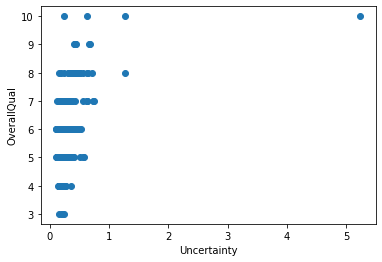

In [263]:
col = "OverallQual"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma, X_test[col] * X_std[col] + X_mean[col])
plt.show()

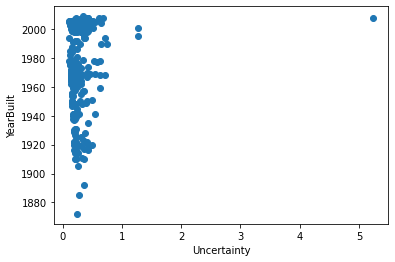

In [265]:
col = "YearBuilt"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma, X_test[col] * X_std[col] + X_mean[col])
plt.show()

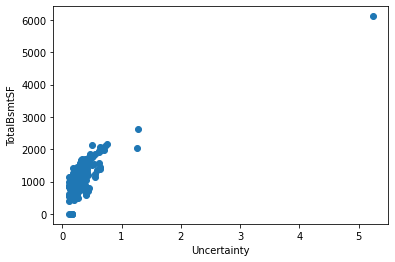

In [266]:
col = "TotalBsmtSF"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma, X_test[col] * X_std[col] + X_mean[col])
plt.show()

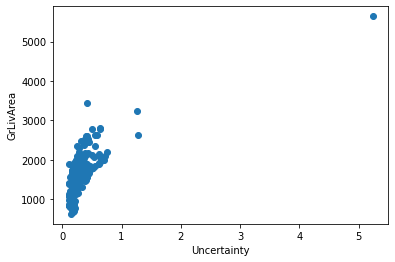

In [267]:
col = "GrLivArea"

plt.xlabel("Uncertainty")
plt.ylabel(col)
plt.scatter(sigma, X_test[col] * X_std[col] + X_mean[col])
plt.show()

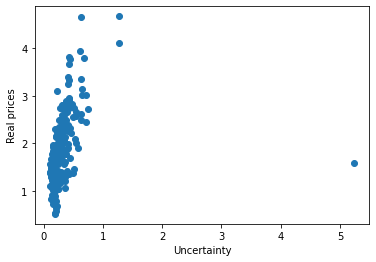

In [268]:
plt.xlabel("Uncertainty")
plt.ylabel("Real prices")
plt.scatter(sigma, y_test)
plt.show()

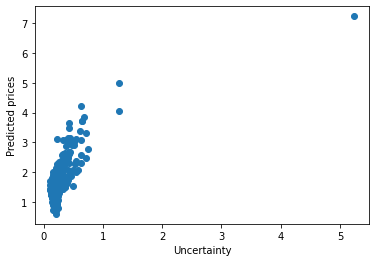

In [269]:
plt.xlabel("Uncertainty")
plt.ylabel("Predicted prices")
plt.scatter(sigma, y_pred[:, 0].detach().cpu().numpy())
plt.show()